# Загрузка данных и препроцессинг


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('data.csv')

Посмотрим на общую информацию о датасете.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


In [5]:
df.sample(5)

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
9056,9057,A,Flight,2,5,243,3,high,M,7,4486,0
5421,5422,B,Ship,6,1,147,3,medium,F,5,4012,0
3113,3114,F,Ship,2,5,151,3,low,M,34,1652,1
662,663,A,Road,4,4,218,5,medium,F,36,2995,1
6149,6150,F,Road,4,5,252,2,high,F,6,4147,1


In [6]:
df.shape

(10999, 12)

In [7]:
df.nunique()

ID                     10999
Warehouse_block            5
Mode_of_Shipment           3
Customer_care_calls        6
Customer_rating            5
Cost_of_the_Product      215
Prior_purchases            8
Product_importance         3
Gender                     2
Discount_offered          65
Weight_in_gms           4034
Reached.on.Time_Y.N        2
dtype: int64

In [8]:
df.isna().sum()

ID                     0
Warehouse_block        0
Mode_of_Shipment       0
Customer_care_calls    0
Customer_rating        0
Cost_of_the_Product    0
Prior_purchases        0
Product_importance     0
Gender                 0
Discount_offered       0
Weight_in_gms          0
Reached.on.Time_Y.N    0
dtype: int64

Разделите наши данные на обучающий и тестовый наборы, а затем масштабируйте числовые значения и кодируйте категориальные значения, используя OHE.

In [9]:
X = df.drop(columns=["Reached.on.Time_Y.N"])
y = df["Reached.on.Time_Y.N"]

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, random_state=0)

In [11]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
categorical_cols = X.select_dtypes(include=["object"]).columns
numeric_cols = X.select_dtypes(include=["int64"]).columns
preprocessor = ColumnTransformer(
    transformers=[("num", StandardScaler(), numeric_cols),
     ("cat", OneHotEncoder(), categorical_cols)]
)
X_train_prepared = preprocessor.fit_transform(X_train)
X_test_prepared = preprocessor.transform(X_test)

# Снижение размерности

## PCA

In [13]:
from sklearn.decomposition import PCA

pca = PCA(random_state=43)
X_train_pca = pca.fit_transform(X_train_prepared)
pca.explained_variance_ratio_

array([2.08954234e-01, 1.72151602e-01, 1.08315339e-01, 9.87818828e-02,
       7.22317199e-02, 5.33986605e-02, 5.19655374e-02, 4.68197777e-02,
       4.06020877e-02, 3.42725267e-02, 2.98501806e-02, 1.86776146e-02,
       1.75880844e-02, 1.67214111e-02, 1.63799145e-02, 1.32894273e-02,
       9.32742446e-18, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

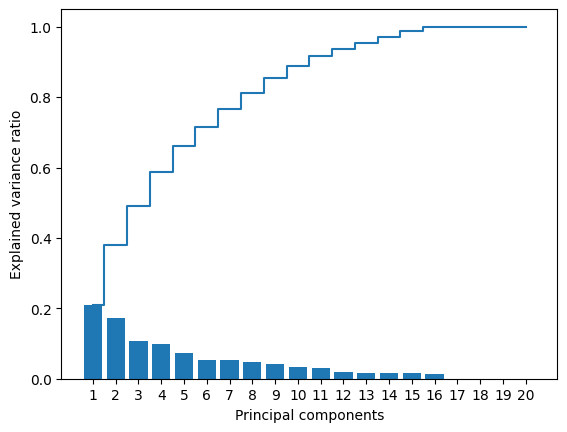

In [14]:
plt.bar(range(1, 21), pca.explained_variance_ratio_, align='center')
plt.step(range(1, 21), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.xticks(range(1, 21))
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.show()

Примерно 10-11 компонентов дадут нам 85-90% объясняемой дисперсии, и мы выберем 11.

In [15]:
pca = PCA(n_components=11, random_state=43)
X_train_pca = pca.fit_transform(X_train_prepared)

Первые пять фичей влияют больше, чем другие. И оптимально использовать n_components=11, так как при этом теряется меньше информации

Для визуализации сделаем 2 и 3 компоненты.

In [16]:
pca_2 = PCA(n_components=2, random_state=43)
X_train_pca_2 = pca_2.fit_transform(X_train_prepared)
pca_2_data = pd.DataFrame({"component_1" : X_train_pca_2[:, 0],
                           "component_2" : X_train_pca_2[:, 1],
                           "target" : y_train})

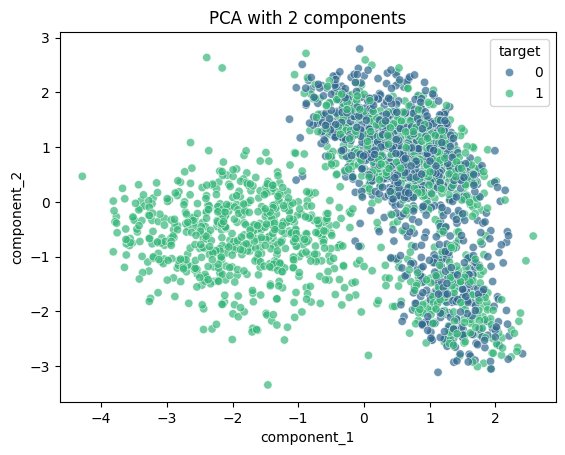

In [17]:
sns.scatterplot(data=pca_2_data, x="component_1", y="component_2", hue="target", palette="viridis", alpha=0.7)
plt.title("PCA with 2 components")
plt.show()

Видно, что есть одна четкая область отделенная от остального облака информации, в котором все перемешено.

In [18]:
pca_3 = PCA(n_components=3, random_state=43)
X_train_pca_3 = pca_3.fit_transform(X_train_prepared)
pca_3_data = pd.DataFrame({"component_1" : X_train_pca_3[:, 0],
                           "component_2" : X_train_pca_3[:, 1],
                             "component_3" : X_train_pca_3[:, 2],
                           "target" : y_train})

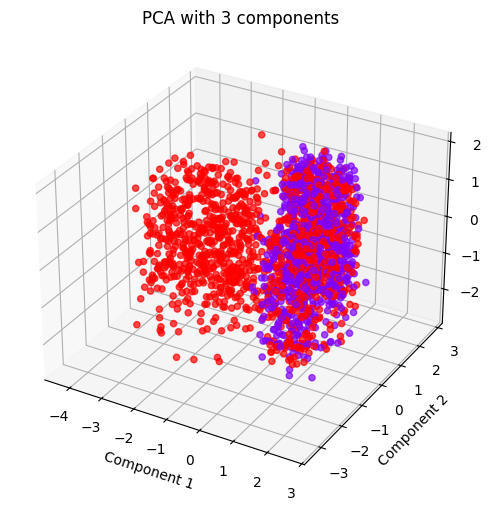

In [19]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train_pca_3[:, 0], X_train_pca_3[:, 1], X_train_pca_3[:, 2], c=y_train, cmap='rainbow', alpha=0.7)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
plt.title('PCA with 3 components')
plt.show()

3 компоненты дают почти такие же результаты.

## LDA

In [21]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=1)
X_train_lda = lda.fit_transform(X_train_prepared, y_train)

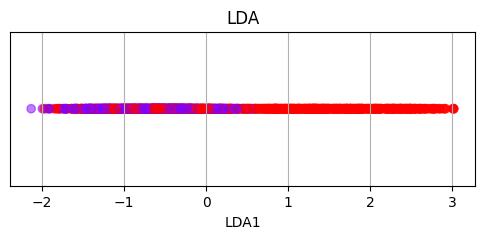

In [22]:
plt.figure(figsize=(6, 2))
plt.title("LDA")
plt.scatter(X_train_lda[:, 0], np.ones(X_train_lda.shape[0]), c=y_train, cmap='rainbow', alpha=0.5)
plt.xlabel("LDA1")
plt.yticks([])
plt.grid(True)
plt.show()

Мы можем разделить набор поездов с помощью компонента LDA 1 около 0,5 на два класса. Но в левой части есть много точек разных классов.

Перейдем к tsne, также посмотрим на 3 компоненты.

## t-SNE

In [23]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=20, random_state=43)
X_train_tsne_2 = tsne.fit_transform(X_train_prepared)
tsne_data_2 = pd.DataFrame({"component_1" : X_train_tsne_2[:, 0],
                          "component_2" : X_train_tsne_2[:, 1],
                          "target" : y_train})

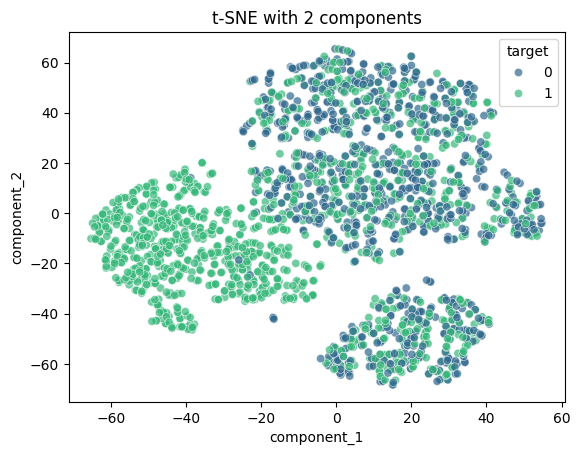

In [24]:
sns.scatterplot(data=tsne_data_2, x="component_1", y="component_2", hue="target", palette="viridis", alpha=0.7)
plt.title("t-SNE with 2 components")
plt.show()

In [25]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=3, perplexity=20, random_state=43)
X_train_tsne_3 = tsne.fit_transform(X_train_prepared)
tsne_data_3 = pd.DataFrame({"component_1" : X_train_tsne_3[:, 0],
                          "component_2" : X_train_tsne_3[:, 1],
                          "target" : y_train})

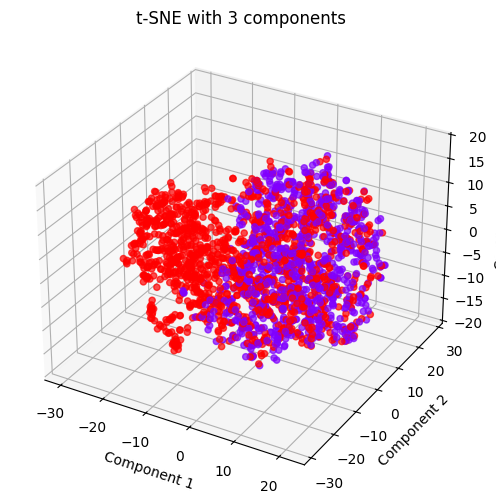

In [26]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train_tsne_3[:, 0], X_train_tsne_3[:, 1], X_train_tsne_3[:, 2], c=y_train, cmap='rainbow', alpha=0.7)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
plt.title('t-SNE with 3 components')
plt.show()

Видно, что как и в двумерном, так и в трехмерном случае конкретно выделяется одно облако ото всей части, где все вперемешку.

## Вывод

При исполользовании всех методов всегда выделялось отдельно облако данных, в котором все объекты строго одного класса, которое четко можно было отделить ото всех остальных данных, но вот в остальных данных все было перемешено. Так же в PCA можно убрать половину всех признаков, особо не потеряв долю объясненной дисперсии, что хорошо.

# Кластеризация

## KMeans

Теперь применим алгоритм KMeans к данным сниженной размерности.

In [ ]:
from sklearn.cluster import KMeans